# Sad songs<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

I'm also on a bit of a Beatles jag, so I've also done the analysis for Beatles songs.

## Contents
### Data gathering

* [Getting data from Spotify](#getspotify)
* [Tag album with artist](#tagalbumwithartist)
* [Tag track with artist](#tagtrackwithartist)
* [Get full track data](#fulltrackdata)
* [Lyrics search](#lyricssearch)
* [Matching datasets](#matchingdatasets)
* [Copy the lyrics over](#copylyrics)
* [Sentiment analysis](#sentimentanalysis)

### Data analysis
* [Analysis](#analysis)
* [Sentiment](#sentiment)
* [Gloom index](#gloomindex)
* [Revised gloom index](#revisedgloomindex)
* [Contrasting songs](#valencenegcontrast)
* [Gloom per album](#gloomperalbum)
* [Complexity per album](#complexityovertime)

### [Conclusion](#conclusion)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [4]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [6]:
# try:
#     client.drop_database(songs_db)
# except NameError:
#     print("DB doesn't exist yet.")

DB doesn't exist yet.


In [5]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [6]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [9]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

# Get album and track data from Spotify<a name='getspotify'></a>
We'll download the data on artists, albums, and tracks from Spotify.

* [Top](#top)

In [7]:
def get_artists(artist_name):
    query = urllib.parse.urlencode({'q': artist_name, 'type': 'artist'})
    request = 'https://api.spotify.com/v1/search?{}'.format(query)
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        artists = []
        for artist in response['artists']['items']:
            if artist['name'].lower() == artist_name.lower():
                this_artist = {'name': artist['name'], 'id': artist['id']}
                if artist['images']:
                    this_artist['image'] = artist['images'][0]['url']
                artists += [this_artist]
    return artists

In [8]:
artists = get_artists('radiohead')
radiohead_id = artists[0]['id']
radiohead_id, artists

('4Z8W4fKeB5YxbusRsdQVPb',
 [{'id': '4Z8W4fKeB5YxbusRsdQVPb',
   'image': 'https://i.scdn.co/image/afcd616e1ef2d2786f47b3b4a8a6aeea24a72adc',
   'name': 'Radiohead'}])

In [9]:
artists = get_artists('the beatles')
beatles_id = artists[0]['id']
beatles_id, artists

('3WrFJ7ztbogyGnTHbHJFl2',
 [{'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'image': 'https://i.scdn.co/image/934c57df9fbdbbaa5e93b55994a4cb9571fd2085',
   'name': 'The Beatles'}])

Find all the albums for an artist.

In [13]:
def get_albums(artist_id):
        request = 'https://api.spotify.com/v1/artists/{id}/albums?market=GB&album_type=album'.format(id=artist_id)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            for a in response['items']:
                album_request = a['href']
                with urllib.request.urlopen(album_request) as af:
                    album = json.loads(af.read().decode('utf-8'))
                    album['_id'] = album['id']
                    albums.replace_one({'_id': album['_id']}, album, upsert=True)

In [14]:
get_albums(beatles_id)
albums.find().count()

48

In [15]:
get_albums(radiohead_id)
albums.find().count()

48

In [16]:
pd.DataFrame(list(albums.find())).head().T

,0,1,2,3,4
_id,5XfJmldgWzrc1AIdbBaVZn,5ju5Ouzan3QwXqQt1Tihbh,2pCqZLeavM2BMovJXsJEIV,2Pqkn9Dq2DFtdfkKAeqgMd,47bcKzmKgmMPHXNVOWpLiu
album_type,album,album,album,album,album
artist_id,NaN,NaN,NaN,NaN,NaN
artist_name,NaN,NaN,NaN,NaN,NaN
artists,"[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'name': 'The...","[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'name': 'The...","[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'name': 'The...","[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'name': 'The...","[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'name': 'The..."
available_markets,"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C..."
copyrights,"[{'text': '(C) 2016 Apple Corps Ltd.', 'type':...","[{'text': '(C) 2015 Apple Corps Ltd.', 'type':...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ..."
external_ids,{'upc': '00602557054989'},{'upc': '00602547673503'},{'upc': '00602547670069'},{'upc': '00602547670342'},{'upc': '00602547670328'}
external_urls,{'spotify': 'https://open.spotify.com/album/5X...,{'spotify': 'https://open.spotify.com/album/5j...,{'spotify': 'https://open.spotify.com/album/2p...,{'spotify': 'https://open.spotify.com/album/2P...,{'spotify': 'https://open.spotify.com/album/47...
genres,[],[],[],[],[]


### Tag albums with artists<a name="tagalbumwithartist"></a>
As we have tracks for two artists, let's keep the identification easy and insert the artist name and id into each track document.

* [Top](#top)

In [17]:
for a in albums.find({}, ['artists']):
    albums.update_one({'_id': a['_id']}, 
                      {'$set': {'artist_name': a['artists'][0]['name'],
                                'artist_id': a['artists'][0]['id']}})

In [18]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


According to the [Spotify documentation](https://developer.spotify.com/web-api/object-model/#track-object), some objects returned have only a bit of the data, and contain a `href` field for where to find the rest. The track details in the album documents fit that bill, so let's find the full track information.

While doing this, not that Spotify will rate-limit the requests, so we have to include a loop to respect the timeout and retry the requests after the appropriate time.

In [19]:
def get_tracks(album_id):
    album = albums.find_one({'_id': album_id})
    for t in album['tracks']['items']:
        for _ in range(10):
            try:
                with urllib.request.urlopen(t['href']) as f:
                    track = json.loads(f.read().decode('utf-8'))
                    track['_id'] = track['id']
                    track['album_id'] = album_id
                    tracks.replace_one({'_id': track['_id']}, track, upsert=True)
                    break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue

In [20]:
for album in albums.find():
    get_tracks(album['_id'])
tracks.find().count()

Rate limited. Pausing for 2
Rate limited. Pausing for 0
Rate limited. Pausing for 0
Rate limited. Pausing for 0
Rate limited. Pausing for 0
Rate limited. Pausing for 0
Rate limited. Pausing for 0


671

In [21]:
pd.DataFrame(list(tracks.find())).head().T

,0,1,2,3,4
_id,0Za26pWVLQpKfXmb9FX10S,6295nz7PVXm49Ihqwm39Ew,0832Tptls5YicHPGgw7ssP,6yq33zsqWCd8cYXQdtAFZ9,5pTWpY8l7B1XcQnijEFGFj
album,{'href': 'https://api.spotify.com/v1/albums/54...,{'href': 'https://api.spotify.com/v1/albums/54...,{'href': 'https://api.spotify.com/v1/albums/54...,{'href': 'https://api.spotify.com/v1/albums/54...,{'href': 'https://api.spotify.com/v1/albums/6F...
album_id,54sqbAXxR1jFfyXb1WvrHK,54sqbAXxR1jFfyXb1WvrHK,54sqbAXxR1jFfyXb1WvrHK,54sqbAXxR1jFfyXb1WvrHK,6FjXxl9VLURGuubdXUn2J3
artists,"[{'id': '22bE4uQ6baNwSHPVcDxLCe', 'name': 'The...","[{'id': '22bE4uQ6baNwSHPVcDxLCe', 'name': 'The...","[{'id': '22bE4uQ6baNwSHPVcDxLCe', 'name': 'The...","[{'id': '22bE4uQ6baNwSHPVcDxLCe', 'name': 'The...","[{'id': '22bE4uQ6baNwSHPVcDxLCe', 'name': 'The..."
available_markets,"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BG, BO, BR, CL, CO, CR, CY, C..."
disc_number,1,1,1,1,1
duration_ms,187440,204960,265173,226800,288666
explicit,False,False,False,False,False
external_ids,{'isrc': 'GBCJN7800007'},{'isrc': 'GBCJN7800008'},{'isrc': 'GBCJN7800009'},{'isrc': 'GBCJN7800010'},{'isrc': 'GBCJN7800001'}
external_urls,{'spotify': 'https://open.spotify.com/track/0Z...,{'spotify': 'https://open.spotify.com/track/62...,{'spotify': 'https://open.spotify.com/track/08...,{'spotify': 'https://open.spotify.com/track/6y...,{'spotify': 'https://open.spotify.com/track/5p...


In [22]:
tracks.find_one({}, 'album.id')

{'_id': '0Za26pWVLQpKfXmb9FX10S'}

### Tag tracks with artist<a name="tagtrackwithartist"></a>
Again, make an easy tag for the artist of each track.

* [Top](#top)

In [23]:
for t in tracks.find({}, ['artists']):
    tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': t['artists'][0]['name'],
                                'artist_id': t['artists'][0]['id']}})

In [24]:
set(t['artist_name'] for t in tracks.find({}))

{'Duke Ellington',
 'George Martin',
 'Jimi Hendrix',
 'Radiohead',
 'The Beatles',
 'The Rolling Stones'}

In [25]:
pd.DataFrame([{'album_id': a['id'], 
              'album_name': a['name'],
              'track_id': t['id'],
              'track_name': t['name'],
              'artist_name': t['artist_name']}
              for a in albums.find()
              for tid in a['tracks']['items']
              for t in tracks.find({'_id': tid['id']})])

,album_id,album_name,artist_name,track_id,track_name
0,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,4edArG2VehvJdwOZfYOxtK,Twist And Shout - Live / Remastered
1,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,150EAeMGWJRubuH8zyx7h8,She's A Woman - Live / Remastered
2,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1fVeHYkyMxrjbjRAD9uWsZ,Dizzy Miss Lizzy - Live / Remastered
3,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,0GRplBEB2FWCKutwMmS6nY,Ticket To Ride - Live / Remastered
4,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1eVymk74iroqhsZxm0Vy3g,Can't Buy Me Love - Live / Remastered
5,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,2p5a9gu6NECVSvBtGSU1vm,Things We Said Today - Live / Remastered
6,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1HyLh5cctOnP186CBi8bhm,Roll Over Beethoven - Live / Remastered
7,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,7fZEWm7TAL2oZDyiYrrgnk,Boys - Live / Remastered
8,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,21nhooOxso7CCoHPE73w4L,A Hard Day's Night - Live / Remastered
9,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1alcPfZWUHh01l4Fnoo5Jt,Help! - Live / Remastered


### Get full track data<a name="fulltrackdata"></a>
The full audio analysis requires an API token to get the data. We use the client token to retreive an authorisation token, which will last for about ten minutes.

* [Top](#top)

In [26]:
def get_spotify_auth_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = urllib.parse.urlencode({'grant_type': 'client_credentials'}).encode('utf-8')
    auth_id = base64.standard_b64encode((config['spotify']['client_id'] + \
        ':' + config['spotify']['client_secret']).encode('utf-8')).decode('utf-8)')
    auth_headers = {'Authorization': 'Basic ' + auth_id}
    auth_request = urllib.request.Request(auth_url, data=auth_data, headers=auth_headers)
    with urllib.request.urlopen(auth_request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response['token_type'], response['access_token']

In [1]:
def get_audio_features(track_ids, auth_type, auth_token):
    url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
    headers = {'Authorization': auth_type + ' ' + auth_token}
    request = urllib.request.Request(url, headers=headers, method='GET')
    
    for _ in range(10):
        try:
            with urllib.request.urlopen(request) as f:
                response = json.loads(f.read().decode('utf-8'))
                for track in response['audio_features']:
                    tracks.update_one({'_id': track['id']}, {'$set': track})
                break
        except urllib.error.HTTPError as e:
            print("Rate limited. Pausing for", e.info()['Retry-After'])
            time.sleep(int(e.info()['Retry-After']) + 0.5)
            continue

In [33]:
a_type, a_token = get_spotify_auth_token()
for a in albums.find({}, []):
    track_ids = [t['_id'] for t in tracks.find({'album.id': a['_id']}, [])]
    get_audio_features(track_ids, a_type, a_token)

Rate limited. Pausing for 2
Rate limited. Pausing for 0
Rate limited. Pausing for 2
Rate limited. Pausing for 0
Rate limited. Pausing for 2
Rate limited. Pausing for 2


In [10]:
beatles_tracks = pd.DataFrame(list(tracks.find({'artist_id': beatles_id})))
beatles_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
_id,2ucFulEWapRAmTn7l6f5Q7,2z1p43SNSbeowzy8WdYHNk,3ckvsHnEffhhS5c0Cs6Gv5,4edArG2VehvJdwOZfYOxtK,150EAeMGWJRubuH8zyx7h8,1fVeHYkyMxrjbjRAD9uWsZ,0GRplBEB2FWCKutwMmS6nY,1eVymk74iroqhsZxm0Vy3g,2p5a9gu6NECVSvBtGSU1vm,1HyLh5cctOnP186CBi8bhm,...,43feVCF6QfqIt9LnLs9BAH,3NwEPV9MDr1z3KcHiAuz9d,2Iccm3cKBQHWt5yk0yX9nh,2OLMjGIhCNI6j34ysPscbp,01n20rdBC5czKAhxmGREkr,5gnrZoSS7nbDYtHp32RFiI,5FBxWhG0nbBAF6lWgJFklM,6tEwCsVtZ5tI8uHNJSHQ3b,50jq8RgbDfmNNd0NiRnl4L,4Z1fbYp0HuxLBje4MOZcSD
acousticness,0.425,0.368,0.614,7.67e-05,0.00675,0.0131,0.00327,0.00865,0.0836,0.00242,...,0.607,0.767,0.334,0.386,0.389,0.778,0.608,0.698,0.629,0.641
album,"{'name': 'The Beatles (Remastered)', 'images':...","{'name': 'Magical Mystery Tour (Remastered)', ...","{'name': 'Beatles For Sale (Remastered)', 'ima...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...","{'name': 'Live At The Hollywood Bowl', 'images...",...,"{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima...","{'name': 'Please Please Me (Remastered)', 'ima..."
album_id,03Qh833fEdVT30Pfs93ea6,6P9yO0ukhOx3dvmhGKeYoC,7BgGBZndAvDlKOcwe5rscZ,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,...,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn
analysis_url,https://api.spotify.com/v1/audio-analysis/2ucF...,https://api.spotify.com/v1/audio-analysis/2z1p...,https://api.spotify.com/v1/audio-analysis/3ckv...,https://api.spotify.com/v1/audio-analysis/4edA...,https://api.spotify.com/v1/audio-analysis/150E...,https://api.spotify.com/v1/audio-analysis/1fVe...,https://api.spotify.com/v1/audio-analysis/0GRp...,https://api.spotify.com/v1/audio-analysis/1eVy...,https://api.spotify.com/v1/audio-analysis/2p5a...,https://api.spotify.com/v1/audio-analysis/1HyL...,...,https://api.spotify.com/v1/audio-analysis/43fe...,https://api.spotify.com/v1/audio-analysis/3NwE...,https://api.spotify.com/v1/audio-analysis/2Icc...,https://api.spotify.com/v1/audio-analysis/2OLM...,https://api.spotify.com/v1/audio-analysis/01n2...,https://api.spotify.com/v1/audio-analysis/5gnr...,https://api.spotify.com/v1/audio-analysis/5FBx...,https://api.spotify.com/v1/audio-analysis/6tEw...,https://api.spotify.com/v1/audio-analysis/50jq...,https://api.spotify.com/v1/audio-analysis/4Z1f...
artist_id,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,...,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2
artist_name,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,...,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles
artists,"[{'name': 'The Beatles', 'id': '3WrFJ7

In [11]:
radiohead_tracks = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id})))
radiohead_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
_id,0eECFDnWy0RdjMmJ8NOeAL,6Unw1AAcpS1ZgZoRlj2jxA,5hfzW7LG97Hxv62HHUKgaj,64lecUR19lBSu317AzVZv3,1CxhtUbe1o2PeMM3l5Kch6,2H7Y8wYixrSlKJoaZ1N2yl,3zkFTfcboFcOdno0CHCmTc,7KKglMFf5KV0PIDSAOqfnH,4raxzmnFq93jfKC8c3xcIv,1gaAIZ4vGQ6QvDUgN2Xyus,...,71wIOoaoVMUwskK5yCXZL4,2zYmvi3w2T8a9Ckrv21bvW,3ovbSnT5NNhl1gzMcw1NRZ,4NUc1M0CS7b6zvWoyvibju,4nklmaiY4gfQI3SB1sLGsd,11qDTSr3Dj4TkPnBcIOqEJ,4D6ZExVvYLZxhcAvifX5px,48IEDejXX5LH8TAC3VIGpc,2B5P22cfUadACK7jLQegU6,6qttbImnJ5wuA8AtDKEy18
acousticness,0.00101,0.00822,0.0589,0.0825,0.102,0.000801,0.0955,0.0147,0.443,0.313,...,0.000659,0.000849,0.704,0.000101,1.93e-05,0.00281,0.000849,0.00968,0.000135,0.000465
album,"{'name': 'The King Of Limbs', 'images': [{'wid...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...","{'name': 'TKOL RMX 1234567', 'images': [{'widt...",...,"{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6...","{'name': 'Pablo Honey', 'images': [{'width': 6..."
album_id,1DBkJIEoeHrTX4WCBQGcCi,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,...,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN
analysis_url,https://api.spotify.com/v1/audio-analysis/0eEC...,https://api.spotify.com/v1/audio-analysis/6Unw...,https://api.spotify.com/v1/audio-analysis/5hfz...,https://api.spotify.com/v1/audio-analysis/64le...,https://api.spotify.com/v1/audio-analysis/1Cxh...,https://api.spotify.com/v1/audio-analysis/2H7Y...,https://api.spotify.com/v1/audio-analysis/3zkF...,https://api.spotify.com/v1/audio-analysis/7KKg...,https://api.spotify.com/v1/audio-analysis/4rax...,https://api.spotify.com/v1/audio-analysis/1gaA...,...,https://api.spotify.com/v1/audio-analysis/71wI...,https://api.spotify.com/v1/audio-analysis/2zYm...,https://api.spotify.com/v1/audio-analysis/3ovb...,https://api.spotify.com/v1/audio-analysis/4NUc...,https://api.spotify.com/v1/audio-analysis/4nkl...,https://api.spotify.com/v1/audio-analysis/11qD...,https://api.spotify.com/v1/audio-analysis/4D6Z...,https://api.spotify.com/v1/audio-analysis/48IE...,https://api.spotify.com/v1/audio-analysis/2B5P...,https://api.spotify.com/v1/audio-analysis/6qtt...
artist_id,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,...,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb
artist_name,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,...,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead
artists,"[{'name': 'Radiohead', 'id': '4Z8W4fKeB5YxbusR...","[{'

How happy are the Beatles and Radiohead tracks?

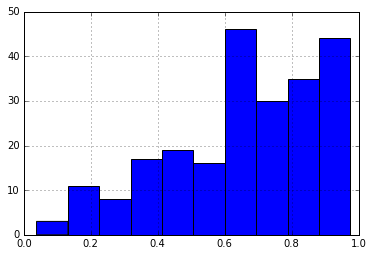

In [12]:
beatles_tracks['valence'].hist()

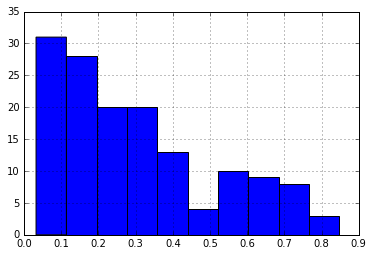

In [13]:
radiohead_tracks['valence'].hist()

## Lyrics search<a name="lyricssearch"></a>
Now to find the lyrics for each track. 

We start by searching for the Genius ID for the artists.

Note that Genius doesn't like Python-generated requests to its API, so we set the header to pretend to be a command-line `curl` request.

* [Top](#top)

In [38]:
def genius_artist_search(artist_name, per_page=20):
    query = urllib.parse.urlencode({'q': artist_name,
                                    'per_page': str(per_page)
                                   })
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request('https://api.genius.com/search?{}'.format(query), 
                                     headers=headers,
                                     method='GET')
    with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            return response

In [39]:
response = genius_artist_search('the beatles')
beatles_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
beatles_genius_id

586

In [40]:
response = genius_artist_search('radiohead')
radiohead_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
radiohead_genius_id

604

We can now get the song information for each track for each artist. Note that Genius keeps lots of things to do with artists, including sleeve notes and the like. We're just after the lyrics.

In [41]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [42]:
genius_song_search(beatles_genius_id)
genius_tracks.find().count()

1071

In [43]:
genius_song_search(radiohead_genius_id)
genius_tracks.find().count()

1071

In [44]:
genius_tracks.find_one()

{'_id': 1497768,
 'annotation_count': 1,
 'api_path': '/songs/1497768',
 'full_title': 'All Together on the Wireless Machine by\xa0The\xa0Beatles',
 'header_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'header_image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'id': 1497768,
 'lyrics_owner_id': 1549345,
 'path': '/The-beatles-all-together-on-the-wireless-machine-lyrics',
 'primary_artist': {'api_path': '/artists/586',
  'header_image_url': 'https://images.genius.com/b82dbb78926a812abfa10886ac84c1a8.1000x523x1.jpg',
  'id': 586,
  'image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
  'is_meme_verified': False,
  'is_verified': False,
  'name': 'The Beatles',
  'url': 'https://genius.com/artists/The-beatles'},
 'pyongs_count': None,
 'song_art_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'stats': {'hot': Fal

In [45]:
gsongs = pd.DataFrame(list(genius_tracks.find()))
gsongs.T

,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
_id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,81705,310483,313269,313043,2389345,1245984,311907,310293,310289,106069
annotation_count,1,1,5,4,6,1,1,6,1,1,...,7,1,1,1,4,1,1,4,1,16
api_path,/songs/1497768,/songs/210315,/songs/123533,/songs/123537,/songs/117722,/songs/210284,/songs/1336394,/songs/107915,/songs/1308579,/songs/123808,...,/songs/81705,/songs/310483,/songs/313269,/songs/313043,/songs/2389345,/songs/1245984,/songs/311907,/songs/310293,/songs/310289,/songs/106069
ctitle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,you cant always get what you want,you cant catch me,you dont have to mean it,you got me rocking,you got the silver,dont look back,each and every day of the year,im a king bee,little by little,brown sugar
full_title,All Together on the Wireless Machine by The Be...,A Little Rhyme by The Beatles (Ft. John & Rodn...,And I Love Her by The Beatles,Any Time at All by The Beatles,A Taste of Honey by The Beatles,Beatle Greetings by The Beatles (Ft. George Ha...,Can You Take Me Back by The Beatles,Carry That Weight by The Beatles,Down in Eastern Australia by The Beatles,Everybody's Trying to Be My Baby by The Beatles,...,You Can't Always Get What You Want by The Roll...,You Can't Catch Me by The Rolling Stones,You Don't Have To Mean It by The Rolling Stones,You Got Me Rocking by The Rolling Stones,You Got the Silver by The Rolling Stones (Ft. ...,Don't Look Back by The Rolling Stones,Each and every day of the year by The Rolling ...,I'm A King Bee by The Rolling Stones,Little By Little by The Rolling Stones,Brown Sugar by The Rolling Stones
header_image_thumbnail_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/7e75133e0e4017798a7a...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...
header_image_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/7e75133e0e4017798a7a...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...
id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,81705,310483,313269,313043,2389345,1245984,311907,310293,310289,106069
lyrics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,i saw her today at the reception a glass of wi...,i bought a 

Now we can get the lyrics for each song. We tidy it up as we go, to strip out formatting and the like.

Note the use of [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip out the HTML from the lyrics.

In [46]:
def genius_lyrics(song_url):
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request(song_url, headers=headers, method='GET')
    html_doc = urllib.request.urlopen(request)
    soup = BeautifulSoup(html_doc, 'html.parser')
    lyrics = soup.find('lyrics').get_text()
    l2 = re.sub('\[[^\]]*\]', '', lyrics)
    l3 = re.sub('\[|\]', '', l2)
    l4 = re.sub('(\s)+', ' ', l3)
    return l4.strip().lower(), lyrics

In [47]:
assl = genius_lyrics('https://genius.com/The-beatles-aint-she-sweet-lyrics')
assl

("oh ain't she sweet well see her walking down that street yes i ask you very confidentially ain't she sweet? oh ain't she nice well look her over once or twice yes i ask you very confidentially ain't she nice? just cast an eye in her direction oh me oh my ain't that perfection? oh i repeat well don't you think that's kind of neat? yes i ask you very confidentially ain't she sweet? oh ain't she sweet well see her walking down that street well i ask you very confidentially ain't she sweet? well i ask you very confidentially ain't she sweet?",
 "\n\n[Chorus 1]]\nOh ain't she sweet\nWell see her walking down that street\nYes I ask you very confidentially\nAin't she sweet?\n\n[Chorus 2]\nOh ain't she nice\nWell look her over once or twice\nYes I ask you very confidentially\nAin't she nice?\n\n[Chorus 3]\nJust cast an eye\nIn her direction\nOh me oh my\nAin't that perfection?\n\n[Chorus 4]\nOh I repeat\nWell don't you think that's kind of neat?\nYes I ask you very confidentially\nAin't she 

In [48]:
for gsong in genius_tracks.find({}, ['url']):
    lyrics, original_lyrics = genius_lyrics(gsong['url'])
    genius_tracks.update_one({'_id': gsong['_id']}, 
                             {'$set': {'lyrics': lyrics, 'original_lyrics': original_lyrics}})
genius_tracks.find_one({}, ['title', 'lyrics', 'original_lyrics'])

{'_id': 1497768,
 'lyrics': 'when i was sitting on my piano one day a magical thought came my way to write a number for the bbc kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine',
 'original_lyrics': '\n\nWhen I was sitting on my piano one day\nA magical thought came my way\nTo write a number for the BBC\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\n\n',
 'title': 'All Together on the Wireless Machine'}

## Matching datasets<a name="matchingdatasets"></a>
Now it's time to match up the datasets. First, we simplify the titles of the tracks, to sidestep differences in punctuation, capitalisation, and the like.

* [Top](#top)

In [49]:
def canonical_name(text):
    t1 = re.sub(' - .*', '', text) # Strip the " - Remastered 2015" suffix
    t2 = re.sub('[^\w\s]', '', t1) # strip all characters except letters, numbers, and whitespace
    t3 = re.sub('\s+', ' ', t2) # collapse whitespace
    return t3.lower() # convert to lowercase and return

In [50]:
canonical_name("A Hard Day's Night - Live / Remastered")

'a hard days night'

Add the simplified title to each track in the Spotify and Genius collections.

In [51]:
for t in tracks.find():
    tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['name'])}})
for t in genius_tracks.find():
    genius_tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['title'])}})

Now to see what the differences are. Find the tracks that are in both collections, and tracks that are in only one.

In [52]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(489, 559, 57)

In [53]:
spotify_only

{'2 2 5 live at earls court',
 'a punch up at a wedding',
 'band introductions',
 'bloom blawan rmx',
 'bloom harmonic 313 rmx',
 'bloom jamie xx rework',
 'bloom mark pritchard rmx',
 'bloom objekt rmx',
 'bullet proof i wish i was',
 'charlies intro to little red rooster',
 'codex illum sphere',
 'dollars cents',
 'dollars cents live',
 'everybody needs somebody to love finale',
 'everything in its right place live in france',
 'faraway eyes',
 'feral lone rmx',
 'fog again live',
 'give up the ghost brokenchord rmx',
 'give up the ghost thriller houseghost remix',
 'good evening mrs magpie modeselektor rmx',
 'i might be wrong live',
 'i will los angeles version',
 'idioteque live in oxford',
 'intro take the a train',
 'jumping jack flash',
 'just my imagination',
 'kansas city heyheyheyhey',
 'key to the highway',
 'like spinning plates live',
 'little by little caribou rmx',
 'little by little shed',
 'little ta',
 'lotus flower jacques greene rmx',
 'lotus flower sbtrkt rmx',
 '

In [54]:
genius_only

{'100 years ago',
 '1822',
 '19th nervous breakdown',
 '2000 light years from home',
 '2000 man',
 '2120 south michigan avenue',
 '3',
 'a little rhyme',
 'a moon shaped pool tracklist album cover',
 'a picture of you',
 'a punchup at a wedding',
 'a reminder',
 'a shot of rhythm and blues',
 'across the universe wildlife version',
 'aint she sweet',
 'aint that loving you baby',
 'aint too proud to beg',
 'all sold out',
 'all things must pass',
 'all together on the wireless machine',
 'andrews blues',
 'another beatles christmas record',
 'anyway you look at it',
 'around and around',
 'baby please dont go',
 'baby whats wrong',
 'backstreet girl',
 'bad boy',
 'bad to me',
 'banana co',
 'beatle greetings',
 'beatles movie medley',
 'beautiful delilah',
 'beautiful dreamer',
 'bebopalula',
 'because i know you love me so',
 'being for the benefit of mr kite take 7',
 'being for the benefit of mr kite takes 1 2',
 'being for the benefit of mr kitei want you shes so heavyhelter skelt

Manually fix a couple of errors.

In [55]:
genius_tracks.update_many({'ctitle': 'revolution i'}, 
                          {'$set': {'ctitle': 'revolution 1'}})
genius_tracks.update_many({'ctitle': 'when im sixtyfour'}, 
                          {'$set': {'ctitle': 'when im sixty four'}})
genius_tracks.update_many({'ctitle': 'packt like sardines in a crushd tin box'}, 
                          {'$set': {'ctitle': 'packt like sardines in a crushed tin box'}})
genius_tracks.update_many({'ctitle': 'a punchup at a wedding'}, 
                          {'$set': {'ctitle': 'a punch up at a wedding'}})
genius_tracks.update_many({'ctitle': 'dollars cents'}, 
                          {'$set': {'ctitle': 'dollars and cents'}})
genius_tracks.update_many({'ctitle': 'bullet proofi wish i was'}, 
                          {'$set': {'ctitle': 'bullet proof i wish i was'}})

In [56]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(494, 554, 52)

### Copy the lyrics over<a name="copylyrics"></a>
Now can can connect the tracks, let's copy across the lyrics from the Genius collection into the Spotify collection. We'll calculate the lyrical density at the same time.

* [Top](#top)

In [57]:
for t in tracks.find({}, ['ctitle', 'duration_ms']):
    gts = genius_tracks.find({'ctitle': t['ctitle'], 'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics'])
    for gt in gts:
        tracks.update_one({'_id': t['_id']}, 
                          {'$set': {'lyrics': gt['lyrics'], 
                                    'original_lyrics': gt['original_lyrics'],
                                    'lyrical_density': 1000 * len(gt['lyrics'].split()) / t['duration_ms']}})

## Sentiment analysis<a name="sentimentanalysis"></a>
I couldn't find an easily-installable equivalent to the NRC corpus, so I'm using a sentiment analysis API endpoint from [Text Processing](http://text-processing.com/docs/sentiment.html).

* [Top](#top)

In [58]:
for t in tracks.find({'lyrics': {'$exists': True}}, ['lyrics']):
    text = t['lyrics']
    if text:
        query = urllib.parse.urlencode({'text': text}).encode('ascii')
        headers = {'Accept': 'application/json',
                   'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('http://text-processing.com/api/sentiment/', 
                                 headers=headers, data=query)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            tracks.update_one({'_id': t['_id']}, {'$set': {'sentiment': response}})

In [59]:
tracks.find_one({'sentiment': {'$exists': True}}).keys()

dict_keys(['sentiment', 'preview_url', 'external_ids', 'duration_ms', 'disc_number', 'track_number', 'album_id', 'href', 'album', 'original_lyrics', 'explicit', 'artist_name', 'lyrics', 'lyrical_density', 'name', 'artist_id', 'type', 'artists', 'external_urls', 'available_markets', 'id', '_id', 'uri', 'popularity', 'ctitle'])

In [60]:
tracks.find_one({'sentiment': {'$exists': True}})

{'_id': '3u06WsJ1KtvEqmmmZqy76J',
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe'},
    'href': 'https://api.spotify.com/v1/artists/22bE4uQ6baNwSHPVcDxLCe',
    'id': '22bE4uQ6baNwSHPVcDxLCe',
    'name': 'The Rolling Stones',
    'type': 'artist',
    'uri': 'spotify:artist:22bE4uQ6baNwSHPVcDxLCe'}],
  'available_markets': ['AD',
   'AR',
   'AT',
   'AU',
   'BG',
   'BO',
   'BR',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DO',
   'EC',
   'EE',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IS',
   'JP',
   'LI',
   'LT',
   'LU',
   'LV',
   'MC',
   'MT',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'PA',
   'PE',
   'PH',
   'PL',
   'PT',
   'PY',
   'SE',
   'SG',
   'SK',
   'SV',
   'TR',
   'TW'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/6FjXxl9VLURGuubdXUn2J3'},
  'href': 'https://api.spotify.

# Analysis<a name="analysis"></a>
Finally, we can get to the analysis of the data!

First, what are the lowest-valence songs, and what's the distribution of valences?

* [Top](#top)

In [61]:
pd.DataFrame(list(tracks.find({}, 
                              ['artist_name', 'name', 'valence'], 
                              sort=[('valence', pymongo.ASCENDING)], limit=20)))

,_id,artist_name,name
0,0B5CEdw4WBs91yn444ZP27,The Rolling Stones,Street Fighting Man - Live
1,7FagS2T3y5XwDpYvyHfvmc,The Rolling Stones,Jumpin' Jack Flash - Live
2,4HKaTAMIXT88muGU1JN9lI,The Rolling Stones,I Go Wild - Live
3,1jgefM2ZP7RnPVShhy1eUM,The Rolling Stones,Not Fade Away - Live
4,74tlMxJ8wF0sNp93GBEPdK,The Rolling Stones,Honky Tonk Women - Live
5,3u06WsJ1KtvEqmmmZqy76J,The Rolling Stones,You Win Again
6,7jZX0QSP4YClL1smfBt1yl,George Martin,Sea Of Time - Remastered 2009
7,4rkGGQEqxHIXVJ4oXjOHgF,George Martin,Sea Of Holes - Remastered 2009
8,2PbwmAMaxIBIWis8XLViat,George Martin,Sea Of Monsters - Remastered 2009
9,7M0HjPZ5KZMik1FYHOU6sR,George Martin,March Of The Meanies - Remastered 2009


Just the Beatles songs.

In [62]:
beatles_df = pd.DataFrame(list(tracks.find({'artist_id': beatles_id}, 
                              ['artist_name', 'name', 'valence'])))
beatles_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,Wild Honey Pie - Remastered 2009,0.153
66,4cLoL5KPfE1hAwfsO84FX7,The Beatles,Because - Remastered 2009,0.162
44,7iABnSNZciNepqGtjMQxxd,The Beatles,Come Together - Remastered 2015,0.178
59,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,Come Together - Remastered 2009,0.179
68,3jPXnX4SskFgAcC4YBKOwN,The Beatles,Sun King - Remastered 2009,0.197
74,0SAqxgrtLO0GzXBeilxHQs,The Beatles,The End - Remastered 2009,0.207
41,4ajbplh2IXiJkXjQiq5aqq,The Beatles,Get Back - Remastered 2015,0.212
67,71Ij3VBYQWMrng61Ae4tBu,The Beatles,You Never Give Me Your Money - Remastered 2009,0.226
1,2z1p43SNSbeowzy8WdYHNk,The Beatles,Flying - Remastered 2009,0.246
72,1llzkEveIzvSXmqqyh7AiB,The Beatles,Golden Slumbers - Remastered 2009,0.250


And plot the valences..

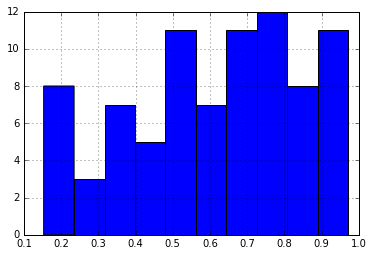

In [63]:
beatles_df['valence'].hist()

In [65]:
radiohead_df = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id}, 
                              ['artist_name', 'name', 'valence'])))
radiohead_df.sort_values('valence').head(10)

,_id,artist_name,name,valence
20,3gKuywOm38axM8sJGq6Laq,Radiohead,MK 1,0.0391
39,4DPQvbgSM0IdX4O3HOACwL,Radiohead,Treefingers,0.0585
37,2mvmuCtmmrERnm03ULdDye,Radiohead,Dollars & Cents,0.0943
1,6Unw1AAcpS1ZgZoRlj2jxA,Radiohead,Little By Little (Caribou Rmx),0.1310
122,05evePUsIT1cmIURp1hgu6,Radiohead,Planet Telex,0.2720
29,3bk7mfQWZ0acgp0hXzYQKS,Radiohead,The National Anthem (Live in France),0.2870
134,1MyqLTRhgyWPw7v107BEuI,Radiohead,You,0.3050
22,3Y0ZPYdFsJ1ynQxpWZLNDj,Radiohead,2 + 2 = 5 (Live at Earls Court),0.3430
78,37kUGdEJJ7NaMl5LFW4EA4,Radiohead,2 + 2 = 5,0.3650
48,3pcCifdPTc2BbqmWpEhtUd,Radiohead,Burn the Witch,0.6250


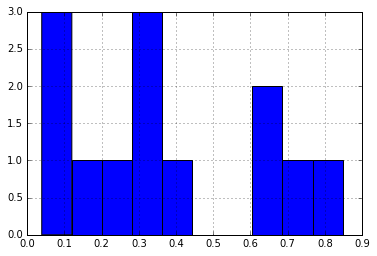

In [66]:
radiohead_df['valence'].hist()

And now plot both on the same chart, to clearly show that Radiohead songs are generally lower-valence than The Beatles.

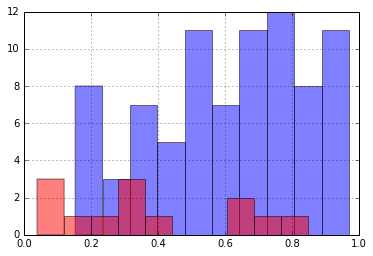

In [67]:
beatles_df['valence'].hist(alpha=0.5, color='blue')
radiohead_df['valence'].hist(alpha=0.5, color='red')

### Sentiment<a name="sentiment"></a>
We can now look at the sentiment scores for the lyrics. We start by looking at the most negative songs for each artist.

* [Top](#top)

In [68]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
beatles_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
beatles_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
62,6gLmFcRwyQCQT23Df2Re9G,The Beatles,I Want You (She's So Heavy) - Remastered 2009,0.882642,0.091819,0.117358,0.416
16,79QDgDoBbS7pCrOjIH7ByA,The Beatles,Everybody’s Trying To Be My Baby - Live / Bonu...,0.866985,0.914332,0.133015,0.639
53,4311wT21Et0q3vepFwXjTu,The Beatles,One After 909 - Remastered 2009,0.865737,0.158470,0.134263,0.904
28,63uskN0xLezVg4281wzeQn,The Beatles,Yesterday - Remastered 2015,0.852156,0.132796,0.147844,0.348
60,59CLXQLZKxRPzMW8S8Gt9N,The Beatles,Oh! Darling - Remastered 2009,0.834624,0.237372,0.165376,0.518
78,69d54YOS8TOQiUYjX57XeA,The Beatles,A Hard Day's Night - Remastered 2009,0.833309,0.188705,0.166691,0.802
9,21nhooOxso7CCoHPE73w4L,The Beatles,A Hard Day's Night - Live / Remastered,0.833309,0.188705,0.166691,0.635
23,0mNQUZEATk2uItMUtiLWK5,The Beatles,A Hard Day's Night - Remastered 2015,0.833309,0.188705,0.166691,0.752
36,0wFW5NQJdNDJPcZyfYSExx,The Beatles,"Hello, Goodbye - Remastered 2015",0.827139,0.163825,0.172861,0.654
4,0GRplBEB2FWCKutwMmS6nY,The Beatles,Ticket To Ride - Live / Remastered,0.825439,0.124786,0.174561,0.405


In [69]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'neutral': '$sentiment.probability.neutral',
                  'pos': '$sentiment.probability.pos'}}
]
radiohead_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
radiohead_df.sort_values('neg', ascending=False).head(10)

,_id,artist_name,name,neg,neutral,pos,valence
2,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,15 Step,0.835488,0.160928,0.164512,0.848
6,1MyqLTRhgyWPw7v107BEuI,Radiohead,You,0.688683,0.340676,0.311317,0.305
5,05evePUsIT1cmIURp1hgu6,Radiohead,Planet Telex,0.646349,0.233964,0.353651,0.272
4,3OsUjkcv1C1v5udFhgRSFg,Radiohead,Airbag,0.642348,0.919411,0.357652,0.642
3,37kUGdEJJ7NaMl5LFW4EA4,Radiohead,2 + 2 = 5,0.637656,0.374924,0.362344,0.365
1,3pcCifdPTc2BbqmWpEhtUd,Radiohead,Burn the Witch,0.582602,0.265249,0.417398,0.625
0,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,Feral,0.465216,0.167266,0.534784,0.751


Plot the valence/negativity scatter plot, using blue for The Beatles and red for Radiohead.

If valence and negativity are correlated, I'd expect to see a trend from high negativity/low valence to low negativity/high valence.

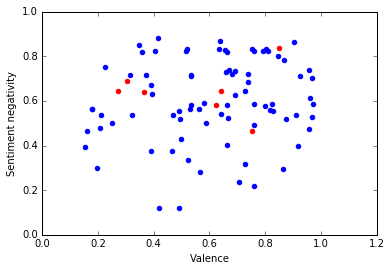

In [70]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='red')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')
plt.show()

Neutrality, I think, is to do with the confidence in the classification.

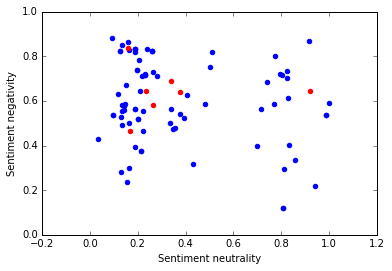

In [71]:
plt.scatter(beatles_df['neutral'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['neutral'], radiohead_df['neg'], color='red')
plt.xlabel('Sentiment neutrality')
plt.ylabel('Sentiment negativity')
plt.show()

This plot shows that most songs have a low neutrality, so express a clear sentiment in the lyrics. Let's plot the distribution of "neutral" scores to highlight this.

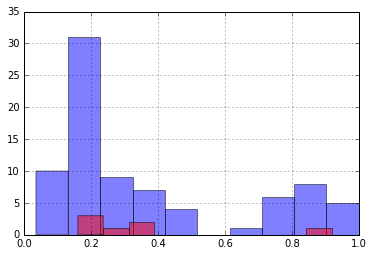

In [72]:
beatles_df['neutral'].hist(alpha=0.5, color='blue')
radiohead_df['neutral'].hist(alpha=0.5, color='red')

### Gloom index<a name="gloomindex"></a>
Let's recreate the "gloom index" idea from the original post and see what it tells us. Bear in mind that I'm using the sentiment negativity score, not the fraction of "sad" words.

* [Top](#top)

In [73]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
5,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.405
95,6j3En9AD8FEAQQhhtkKBR9,The Rolling Stones,1.405004,3.749956,Continental Drift - Live - 2009 Re-Mastered Di...,0.408216,0.129
74,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.261539,2.616693,Her Majesty - Remastered 2009,0.556608,0.490
24,0mNQUZEATk2uItMUtiLWK5,The Beatles,1.213645,1.615224,A Hard Day's Night - Remastered 2015,0.833309,0.752
78,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.210378,1.648037,Help! - Remastered 2009,0.823915,0.761
11,1alcPfZWUHh01l4Fnoo5Jt,The Beatles,1.203416,1.332561,Help! - Live / Remastered,0.823915,0.515
28,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.187438,1.651824,Help! - Remastered 2015,0.823915,0.810
79,69d54YOS8TOQiUYjX57XeA,The Beatles,1.183059,1.601816,A Hard Day's Night - Remastered 2009,0.833309,0.802
29,63uskN0xLezVg4281wzeQn,The Beatles,1.180468,1.005426,Yesterday - Remastered 2015,0.852156,0.348
53,03v6sgKUUFliGse1h04ecC,The Beatles,1.163491,1.061776,I've Got A Feeling - Remastered 2009,0.817733,0.359


Interestingly, the gloomiest songs seem pretty evenly spread between Radiohead and The Beatles.

In [74]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': radiohead_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
3,37kUGdEJJ7NaMl5LFW4EA4,Radiohead,0.981767,1.083467,2 + 2 = 5,0.637656,0.365
6,1MyqLTRhgyWPw7v107BEuI,Radiohead,0.833758,0.412140,You,0.688683,0.305
5,05evePUsIT1cmIURp1hgu6,Radiohead,0.828065,0.435957,Planet Telex,0.646349,0.272
2,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.775417,0.674272,15 Step,0.835488,0.848
1,3pcCifdPTc2BbqmWpEhtUd,Radiohead,0.606884,0.439692,Burn the Witch,0.582602,0.625
4,3OsUjkcv1C1v5udFhgRSFg,Radiohead,0.606161,0.329999,Airbag,0.642348,0.642
0,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.378831,0.093389,Feral,0.465216,0.751


These, in theory, are the most depressing Radiohead songs. For information, the [fitteR happieR songs](http://rcharlie.com/2017-02-16-fitteR-happieR/) were:

  | gloom_index|               track_name
--|------------|--------------------------|
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape

...which has only one song in common, "Let Down". I'm not convinced by this analysis.

What does the same analysis say for The Beatles?

In [75]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
               'artist_id': beatles_id}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density',
                  'gloom': {'$divide': [{'$add': [{'$subtract': [1, '$valence']},
                                                  {'$multiply': ['$sentiment.probability.neg', 
                                                                 {'$add': ['$lyrical_density', 1]}]}]}, 
                                        2]}}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))
results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,gloom,lyrical_density,name,neg,valence
4,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.475037,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.405
73,5H9q6ctIlamkqukdTrNt3k,The Beatles,1.261539,2.616693,Her Majesty - Remastered 2009,0.556608,0.490
23,0mNQUZEATk2uItMUtiLWK5,The Beatles,1.213645,1.615224,A Hard Day's Night - Remastered 2015,0.833309,0.752
77,5ou2BiQ9FxIYkxsYvYHpAT,The Beatles,1.210378,1.648037,Help! - Remastered 2009,0.823915,0.761
10,1alcPfZWUHh01l4Fnoo5Jt,The Beatles,1.203416,1.332561,Help! - Live / Remastered,0.823915,0.515
27,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.187438,1.651824,Help! - Remastered 2015,0.823915,0.810
78,69d54YOS8TOQiUYjX57XeA,The Beatles,1.183059,1.601816,A Hard Day's Night - Remastered 2009,0.833309,0.802
28,63uskN0xLezVg4281wzeQn,The Beatles,1.180468,1.005426,Yesterday - Remastered 2015,0.852156,0.348
52,03v6sgKUUFliGse1h04ecC,The Beatles,1.163491,1.061776,I've Got A Feeling - Remastered 2009,0.817733,0.359
1,4edArG2VehvJdwOZfYOxtK,The Beatles,1.161653,2.823318,Twist And Shout - Live / Remastered,0.499908,0.588


### Revised gloom index<a name="revisedgloomindex"></a>
I don't like the calculation for gloom index. If the point of "lyrical density" is to scale the gloom index between valence and sentiment, depending on how many words are in the song. Let's do that weighting properly.

$$gloom = \frac{(1 - normedLyricDensity)\times(1 - valence) + normedLyricDensity \times negativity }{2}$$

* [Top](#top)

In [76]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': {'artist_name': '$artist_name',
                  'name': '$name',
                  'valence': '$valence',
                  'neg': '$sentiment.probability.neg',
                  'lyrical_density': '$lyrical_density'}}]
results = pd.DataFrame(list(tracks.aggregate(pipeline)))

# Use pandas to scale the lyrical density values to the range 0 -1
results['scaled_ld'] = (results['lyrical_density'] - results['lyrical_density'].min()) / \
    (results['lyrical_density'].max() - results['lyrical_density'].min())

# Define a Python function to calculate the revised gloom index
def gloom(row):
    w_valence = (1 - row['valence']) * (1 - row['scaled_ld'])
    w_neg = row['neg'] * row['scaled_ld']
    return (w_valence + w_neg) / 2

# Apply this function to create a new column
results['gloom'] = results.apply(gloom, axis=1)

# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'gloom': row.gloom}})

results.sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered 2009,0.391178,0.153,0.020924,0.418731
65,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered 2009,0.466254,0.162,0.063602,0.407178
67,3jPXnX4SskFgAcC4YBKOwN,The Beatles,0.273472,Sun King - Remastered 2009,0.300809,0.197,0.049249,0.389134
91,20eJRZyvdYZ5Bx7nHs570i,The Rolling Stones,0.711824,Neighbours - Live Licks Tour - 2009 Re-Mastere...,0.728527,0.212,0.169130,0.388971
43,7iABnSNZciNepqGtjMQxxd,The Beatles,0.800176,Come Together - Remastered 2015,0.562552,0.178,0.193293,0.385925
58,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,0.796316,Come Together - Remastered 2009,0.562552,0.179,0.192237,0.385658
66,71Ij3VBYQWMrng61Ae4tBu,The Beatles,0.592658,You Never Give Me Your Money - Remastered 2009,0.753448,0.226,0.136541,0.385597
73,0SAqxgrtLO0GzXBeilxHQs,The Beatles,0.543735,The End - Remastered 2009,0.478610,0.207,0.123161,0.377140
86,05evePUsIT1cmIURp1hgu6,Radiohead,0.435957,Planet Telex,0.646349,0.272,0.093686,0.360175
40,4ajbplh2IXiJkXjQiq5aqq,The Beatles,1.168048,Get Back - Remastered 2015,0.538810,0.212,0.293898,0.357382


In [77]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
86,05evePUsIT1cmIURp1hgu6,Radiohead,0.435957,Planet Telex,0.646349,0.272,0.093686,0.360175
87,1MyqLTRhgyWPw7v107BEuI,Radiohead,0.412140,You,0.688683,0.305,0.087172,0.347225
84,37kUGdEJJ7NaMl5LFW4EA4,Radiohead,1.083467,2 + 2 = 5,0.637656,0.365,0.270767,0.317860
82,3pcCifdPTc2BbqmWpEhtUd,Radiohead,0.439692,Burn the Witch,0.582602,0.625,0.094707,0.197331
85,3OsUjkcv1C1v5udFhgRSFg,Radiohead,0.329999,Airbag,0.642348,0.642,0.064708,0.188200
83,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.158860,0.130290
1,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.093389,Feral,0.465216,0.751,0.000000,0.124500


This still isn't the same as the original list, though there are now two songs in common!


  | gloom_index |               track_name
--|-------------|--------------------------
1 |        1.00 |           True Love Waits
2 |        6.46 |        Give Up The Ghost
3 |        9.35 | Motion Picture Soundtrack
4 |       13.70 |                 Let Down
5 |       14.15 |             Pyramid Song
6 |       14.57 |  Exit Music (For a Film)
7 |       15.29 |          Dollars & Cents
8 |       15.69 |              High And Dry
9 |       15.80 | Tinker Tailor Soldier ...
10|       16.03 |                Videotape


In [78]:
results[results['artist_name'] == 'The Beatles'].sort_values('gloom', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered 2009,0.391178,0.153,0.020924,0.418731
65,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered 2009,0.466254,0.162,0.063602,0.407178
67,3jPXnX4SskFgAcC4YBKOwN,The Beatles,0.273472,Sun King - Remastered 2009,0.300809,0.197,0.049249,0.389134
43,7iABnSNZciNepqGtjMQxxd,The Beatles,0.800176,Come Together - Remastered 2015,0.562552,0.178,0.193293,0.385925
58,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,0.796316,Come Together - Remastered 2009,0.562552,0.179,0.192237,0.385658
66,71Ij3VBYQWMrng61Ae4tBu,The Beatles,0.592658,You Never Give Me Your Money - Remastered 2009,0.753448,0.226,0.136541,0.385597
73,0SAqxgrtLO0GzXBeilxHQs,The Beatles,0.543735,The End - Remastered 2009,0.478610,0.207,0.123161,0.377140
40,4ajbplh2IXiJkXjQiq5aqq,The Beatles,1.168048,Get Back - Remastered 2015,0.538810,0.212,0.293898,0.357382
5,0GRplBEB2FWCKutwMmS6nY,The Beatles,1.853118,Ticket To Ride - Live / Remastered,0.825439,0.405,0.481252,0.352950
29,63uskN0xLezVg4281wzeQn,The Beatles,1.005426,Yesterday - Remastered 2015,0.852156,0.348,0.249425,0.350962


I don't know the Radiohead corpus, but I know some Beatles songs. _Blue Jay Way_ is pretty sad, as is _A Day in the Life_. _Revolution 9_ and _Wild Honey Pie_ are just... odd, rather than sad. It's suspicious that some obviously sad Beatles songs are missing. What does this analysis think of unequivocally sad songs like _She's Leaving Home_, _Yesterday_, and _Eleanor Rigby_?

In [79]:
slh = tracks.find_one({'ctitle': 'shes leaving home'})['_id']
yd = tracks.find_one({'ctitle': 'yesterday'})['_id']
er = tracks.find_one({'ctitle': 'eleanor rigby'})['_id']
results[results['_id'].isin([slh, yd, er])].sort_values('gloom', ascending=False)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
29,63uskN0xLezVg4281wzeQn,The Beatles,1.005426,Yesterday - Remastered 2015,0.852156,0.348,0.249425,0.350962
34,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.419879,0.213589


### Glee index: anti-gloom<a name="gleeindex"></a>
Rather than looking at the saddest songs, how about using the same data to find the happiest songs?

* [Top](#top)

In [80]:
results.sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
56,0cJ053ljI4BuP5P8tJnK5j,The Beatles,0.893485,For You Blue - Remastered 2009,0.471827,0.958,0.218811,0.068025
101,4Q75gU2hFVL4oxqFpTiT3c,The Rolling Stones,0.501468,Dance (pt 1) - 2009 Re-Mastered Digital Version,0.697406,0.905,0.111602,0.081115
20,2Q2Gu7Bv8iLenuygtBgDUw,The Beatles,1.058884,From Me To You - Mono / Remastered 2015,0.529415,0.968,0.264044,0.081670
48,72Ob0wrObCXgvGYhFs8vip,The Beatles,0.938049,Across The Universe - Remastered 2009,0.295525,0.862,0.230998,0.087194
25,0Gm34HBxrXlaAf1jdJMjx2,The Beatles,1.184094,I Feel Fine - Remastered 2015,0.398252,0.918,0.298287,0.088167
100,6ml6iL8HUdQKgtMaehAZc8,The Rolling Stones,1.215580,Start Me Up - 2009 Re-Mastered Digital Version,0.524795,0.971,0.306898,0.090579
81,63nTBScSLXWwyeizXi9Rmi,The Beatles,1.103784,I Saw Her Standing There - Remastered 2009,0.583951,0.971,0.276324,0.091173
88,0Za26pWVLQpKfXmb9FX10S,The Rolling Stones,1.013658,Respectable - Remastered,0.475156,0.899,0.251676,0.097583
46,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered 2009,0.711080,0.923,0.216642,0.107184
54,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.170971,0.113801


All the top ten most gleeful songs are from The Beatles!

What about the most gleeful Radiohead songs?

In [81]:
results[results['artist_name'] == 'Radiohead'].sort_values('gloom', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
1,0eECFDnWy0RdjMmJ8NOeAL,Radiohead,0.093389,Feral,0.465216,0.751,0.000000,0.124500
83,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.158860,0.130290
85,3OsUjkcv1C1v5udFhgRSFg,Radiohead,0.329999,Airbag,0.642348,0.642,0.064708,0.188200
82,3pcCifdPTc2BbqmWpEhtUd,Radiohead,0.439692,Burn the Witch,0.582602,0.625,0.094707,0.197331
84,37kUGdEJJ7NaMl5LFW4EA4,Radiohead,1.083467,2 + 2 = 5,0.637656,0.365,0.270767,0.317860
87,1MyqLTRhgyWPw7v107BEuI,Radiohead,0.412140,You,0.688683,0.305,0.087172,0.347225
86,05evePUsIT1cmIURp1hgu6,Radiohead,0.435957,Planet Telex,0.646349,0.272,0.093686,0.360175


### Contrasting songs<a name="valencenegcontrast"></a>
Going back to the scatter plot of negativity against valence, there are some songs with a high valence (i.e. sound happy) with a high negativity (i.e. sad words). This seems unusual. What songs are they?

* [Top](#top)

These are the songs I mean:

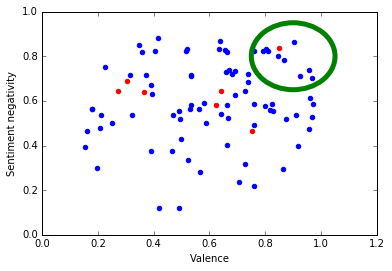

In [82]:
plt.scatter(beatles_df['valence'], beatles_df['neg'], color='blue')
plt.scatter(radiohead_df['valence'], radiohead_df['neg'], color='red')
plt.xlabel('Valence')
plt.ylabel('Sentiment negativity')

ax = plt.gca()
circ = plt.Circle((0.9, 0.8), radius=0.15, color='g', fill=False, linewidth=5)
ax.add_patch(circ)

plt.show()

In [83]:
results[(results['valence'] > 0.8) & (results['neg'] > 0.7)]

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom
23,7pQAq14Z73YUFMtxCyt0bG,The Beatles,1.516618,Can't Buy Me Love - Remastered 2015,0.738387,0.957,0.389226,0.156831
28,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.651824,Help! - Remastered 2015,0.823915,0.810,0.426202,0.230088
34,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.419879,0.213589
46,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered 2009,0.711080,0.923,0.216642,0.107184
54,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.170971,0.113801
68,67jL5ZAf8hNsRZrfBHNuBT,The Beatles,1.277562,Mean Mr Mustard - Remastered 2009,0.700631,0.967,0.323848,0.124606
79,69d54YOS8TOQiUYjX57XeA,The Beatles,1.601816,A Hard Day's Night - Remastered 2009,0.833309,0.802,0.412526,0.230041
80,5tNjuWwp6FxuWCrKQAMBTj,The Beatles,0.959614,It Won't Be Long - Remastered 2009,0.783388,0.868,0.236896,0.143155
83,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.158860,0.130290
89,5pTWpY8l7B1XcQnijEFGFj,The Rolling Stones,1.015010,Miss You - Remastered,0.759348,0.825,0.252046,0.161141


That's interesting. This list contains a lot of the Beatles' most well-known songs. Is there something in this?

Let's define "complexity" as the product of valence and negativity, and see which are the most complext songs.

In [84]:
results['complexity'] = results['valence'] * results['neg']
results.sort_values('complexity', ascending=False).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
54,4311wT21Et0q3vepFwXjTu,The Beatles,0.718556,One After 909 - Remastered 2009,0.865737,0.904,0.170971,0.113801,0.782626
83,6dsq7Nt5mIFzvm5kIYNORy,Radiohead,0.674272,15 Step,0.835488,0.848,0.158860,0.130290,0.708494
23,7pQAq14Z73YUFMtxCyt0bG,The Beatles,1.516618,Can't Buy Me Love - Remastered 2015,0.738387,0.957,0.389226,0.156831,0.706636
80,5tNjuWwp6FxuWCrKQAMBTj,The Beatles,0.959614,It Won't Be Long - Remastered 2009,0.783388,0.868,0.236896,0.143155,0.679980
34,0TRkjwb4uY3CHb5zhr9bBd,The Beatles,1.628703,Eleanor Rigby - Remastered 2015,0.803232,0.845,0.419879,0.213589,0.678731
68,67jL5ZAf8hNsRZrfBHNuBT,The Beatles,1.277562,Mean Mr Mustard - Remastered 2009,0.700631,0.967,0.323848,0.124606,0.677510
79,69d54YOS8TOQiUYjX57XeA,The Beatles,1.601816,A Hard Day's Night - Remastered 2009,0.833309,0.802,0.412526,0.230041,0.668314
28,1dfuJYDSIc41cw5RPsaCF1,The Beatles,1.651824,Help! - Remastered 2015,0.823915,0.810,0.426202,0.230088,0.667371
46,57n1teNb2tkcfiYagPmUWr,The Beatles,0.885556,Two Of Us - Remastered 2009,0.711080,0.923,0.216642,0.107184,0.656327
27,6pkjW5srxjzRSKKMrl7et8,The Beatles,1.425416,Ticket To Ride - Remastered 2015,0.825439,0.793,0.364283,0.216143,0.654573


There's possibly something in it. The most "complex" song has a very upbeat pop tune and very sad lyrics. The others are similarly interesting.

What about the least "complex" songs?

In [85]:
results.sort_values('complexity', ascending=True).head(10)

,_id,artist_name,lyrical_density,name,neg,valence,scaled_ld,gloom,complexity
51,5V1AHQugSTASVez5ffJtFo,The Beatles,0.999889,Let It Be - Remastered 2009,0.119858,0.418,0.247910,0.233715,0.050101
95,6j3En9AD8FEAQQhhtkKBR9,The Rolling Stones,3.749956,Continental Drift - Live - 2009 Re-Mastered Di...,0.408216,0.129,1.000000,0.204108,0.052660
44,22QadBPe0QCuqraFVAr1m3,The Beatles,1.054504,Let It Be - Remastered 2015,0.119858,0.490,0.262846,0.203726,0.058730
67,3jPXnX4SskFgAcC4YBKOwN,The Beatles,0.273472,Sun King - Remastered 2009,0.300809,0.197,0.049249,0.389134,0.059259
0,2ucFulEWapRAmTn7l6f5Q7,The Beatles,0.169898,Wild Honey Pie - Remastered 2009,0.391178,0.153,0.020924,0.418731,0.059850
65,4cLoL5KPfE1hAwfsO84FX7,The Beatles,0.325955,Because - Remastered 2009,0.466254,0.162,0.063602,0.407178,0.075533
94,1FMQd25wsXU14lg323zyNa,The Rolling Stones,0.856393,Love Is Strong - 2009 Re-Mastered Digital Version,0.185872,0.500,0.208667,0.217226,0.092936
73,0SAqxgrtLO0GzXBeilxHQs,The Beatles,0.543735,The End - Remastered 2009,0.478610,0.207,0.123161,0.377140,0.099072
43,7iABnSNZciNepqGtjMQxxd,The Beatles,0.800176,Come Together - Remastered 2015,0.562552,0.178,0.193293,0.385925,0.100134
58,0MKqeOVdZcUFGJvWpGCKbG,The Beatles,0.796316,Come Together - Remastered 2009,0.562552,0.179,0.192237,0.385658,0.100697


Interestingly, all of the "complex" songs are by The Beatles, while most of the least "complex" songs are by Radiohead. How true is that for all songs?

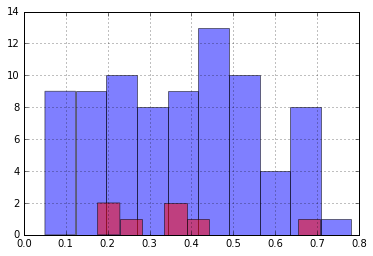

In [86]:
results[results['artist_name'] == 'The Beatles']['complexity'].hist(alpha=0.5, color='blue')
results[results['artist_name'] == 'Radiohead']['complexity'].hist(alpha=0.5, color='red')

In [87]:
# Push the results back into the database
for row in results.itertuples():
    tracks.update_one({'_id': row[1]}, {'$set': {'complexity': row.complexity}})

### Average gloom per album<a name="gloomperalbum"></a>
How close can we easily get to the final plot at the end of the fitteR happieR post?

First, we find average gloom per album.

* [Top](#top)

In [88]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_gloom': {'$avg': '$gloom'}}}]
album_glooms = collections.defaultdict(int, {a['_id']: a['avg_gloom'] for a in tracks.aggregate(pipeline)})
album_glooms

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.41873123282422453,
             '064eFGemsrDcMvgRZ0gqtw': 0.3179832944377065,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.1455414524235663,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.26738524887279513,
             '19K3IHYeVkUTjcBHGfbCOi': 0.24384292409425667,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.1245,
             '1PULmKbHeOqlkIwcDMNwD4': 0.19061203689895245,
             '1TpcI1LEFVhBvDPSTMPGFG': 0.22645560872562193,
             '1W1UJulgICjFDyYIMUwRs7': 0.20410800181164113,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.2342652983252492,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.09057907764772204,
             '1oW3v5Har9mvXnGk0x4fHm': 0.3178595468054327,
             '25mfHGJNQkluvIqedXHSx3': 0.25702782412487735,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.28450005051734983,
             '2pCqZLeavM2BMovJXsJEIV': 0.21201262788418518,
             '2wZgoXS06wSdu9C0ZJOvlc': 0.08111482492357687,
             '3OdI6e43crvyAHhaqpxSyz': 0

In [89]:
albums_df = pd.DataFrame(list(albums.find({}, ['release_date', 'name', 'artist_name'])))

def try_date(d):
    try:
        return datetime.strptime(d, "%Y-%m-%d")
    except ValueError:
        return datetime.strptime(d, "%Y")

albums_df['release_date'] = albums_df['release_date'].apply(lambda d: try_date(d))
albums_df['gloom'] = albums_df['_id'].apply(lambda i: album_glooms[i])
albums_df.sort_values('release_date', inplace=True)
albums_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.091173
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.143155
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.230041
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.000000
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.243843
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.159889
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.145541
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.190612
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.000000
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.418731


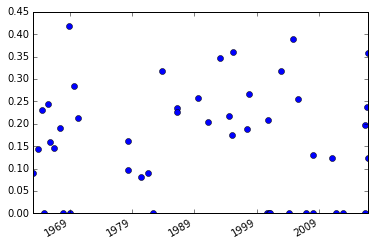

In [90]:
fig, ax = plt.subplots()
ax.plot_date(albums_df['release_date'], albums_df['gloom'])

fig.autofmt_xdate()
plt.show()

One thing that's noticable is the split in time between the groups, and the much shorter period the Beatles were active for.

In [91]:
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
beatles_df

,_id,artist_name,name,release_date,gloom
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.091173
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.143155
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.230041
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.000000
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.243843
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03,0.159889
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05,0.145541
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01,0.190612
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27,0.000000
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22,0.418731


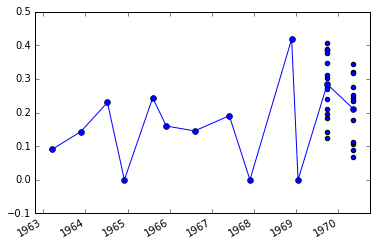

In [92]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['gloom'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

plt.show()

In [93]:
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
radiohead_df

,_id,artist_name,name,release_date,gloom
27,6400dnyeDyD2mIFHfkwHXN,Radiohead,Pablo Honey,1993-02-22,0.347225
26,500FEaUzn8lN9zWFyZG5C2,Radiohead,The Bends,1995-03-28,0.360175
25,7dxKtc08dYeRVHt3p9CZJn,Radiohead,OK Computer,1997-05-28,0.188200
21,1oW3v5Har9mvXnGk0x4fHm,Radiohead,Hail To the Thief,2003-01-01,0.317860
18,7eyQXxuf2nGj9d2367Gi5f,Radiohead,In Rainbows,2007-12-28,0.130290
13,1DBkJIEoeHrTX4WCBQGcCi,Radiohead,The King Of Limbs,2011-02-18,0.124500
16,6vuykQgDLUCiZ7YggIpLM9,Radiohead,A Moon Shaped Pool,2016-05-08,0.197331


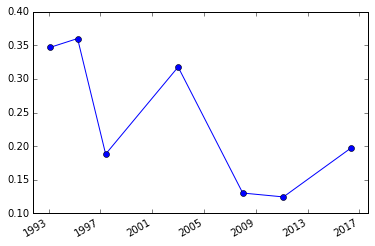

In [94]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['gloom'].values, linestyle='-')

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'gloom': {'$exists': True}}):
        ax.scatter(a.release_date, t['gloom'])

fig.autofmt_xdate()
plt.show()

## Complexity per album<a name="complexityovertime"></a>
Let's generate the same plots for "complexity" per album.

* [Top](#top)

In [95]:
pipeline = [
    {'$match': {'gloom': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_complexity': {'$avg': '$complexity'}}}]
album_complexities = collections.defaultdict(int, {a['_id']: a['avg_complexity'] for a in tracks.aggregate(pipeline)})
album_complexities

defaultdict(int,
            {'03Qh833fEdVT30Pfs93ea6': 0.0598501781172226,
             '064eFGemsrDcMvgRZ0gqtw': 0.3355120536377068,
             '0PYyrqs9NXtxPhf0CZkq2L': 0.46196488464852764,
             '0ZGddnvcVzHVHfE3WW1tV5': 0.46118307452169804,
             '19K3IHYeVkUTjcBHGfbCOi': 0.626999083242065,
             '1DBkJIEoeHrTX4WCBQGcCi': 0.34937728065848533,
             '1PULmKbHeOqlkIwcDMNwD4': 0.15933465315198164,
             '1TpcI1LEFVhBvDPSTMPGFG': 0.38446875479914316,
             '1W1UJulgICjFDyYIMUwRs7': 0.052659864467403415,
             '1WSfNoPDPzgyKFN6OSYWUx': 0.369845537500919,
             '1YvnuYGlblQ5vLnOhaZzpn': 0.5095755952848693,
             '1oW3v5Har9mvXnGk0x4fHm': 0.23274435359579732,
             '25mfHGJNQkluvIqedXHSx3': 0.4267182570832075,
             '2Pqkn9Dq2DFtdfkKAeqgMd': 0.28015413095314634,
             '2pCqZLeavM2BMovJXsJEIV': 0.354664325706374,
             '2wZgoXS06wSdu9C0ZJOvlc': 0.6311525754839657,
             '3OdI6e43crvyAHhaqpx

In [96]:
albums_df['complexity'] = albums_df['_id'].apply(lambda i: album_complexities[i])
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]
albums_df.head()

,_id,artist_name,name,release_date,gloom,complexity
15,7gDXyW16byCQOgK965BRzn,The Beatles,Please Please Me (Remastered),1963-03-22,0.091173,0.567017
14,3nkEsxmIX0zRNXGAexaHAn,The Beatles,With The Beatles (Remastered),1963-11-22,0.143155,0.679980
12,71Mwd9tntFQYUk4k2DwA0D,The Beatles,A Hard Day's Night (Remastered),1964-07-10,0.230041,0.668314
11,7BgGBZndAvDlKOcwe5rscZ,The Beatles,Beatles For Sale (Remastered),1964-12-04,0.000000,0.000000
10,19K3IHYeVkUTjcBHGfbCOi,The Beatles,Help! (Remastered),1965-08-06,0.243843,0.626999


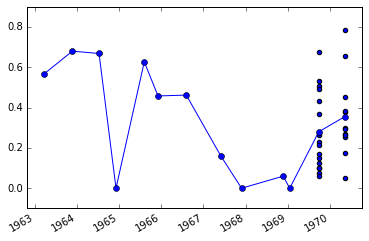

In [97]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

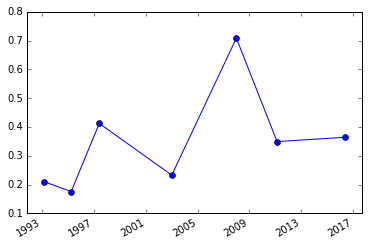

In [98]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'])

plt.show()

That isn't what I was expecting. I was expecting the complexity to go up over time, as bands became more adept at contrasting lyrics and melody. It could be because high complexity requires high valence, and bands tend not to become more "poppy" over time.

Let's test that, by also showing the valence of tracks and albums over time.

In [99]:
pipeline = [
    {'$match': {'valence': {'$exists': True}}},
    {'$group': {'_id': '$album.id', 'avg_valence': {'$avg': '$valence'}}}]
album_valences = collections.defaultdict(int, {a['_id']: a['avg_valence'] for a in tracks.aggregate(pipeline)})
albums_df['valence'] = albums_df['_id'].apply(lambda i: album_valences[i])
beatles_df = albums_df[albums_df['release_date'] < datetime(1971, 1, 1)]
radiohead_df = albums_df[(albums_df['artist_name'] == 'Radiohead') & (albums_df['gloom'] > 0)]

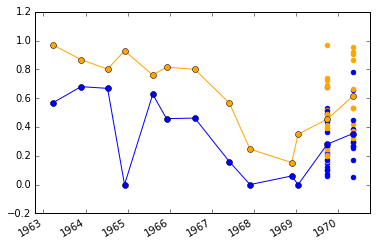

In [100]:
fig, ax = plt.subplots()
ax.plot_date(beatles_df['release_date'].values, beatles_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(beatles_df['release_date'].values, beatles_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in beatles_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

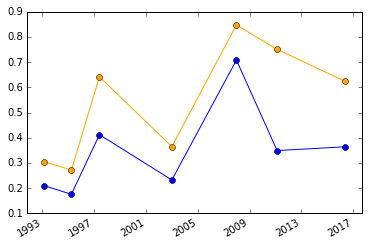

In [101]:
fig, ax = plt.subplots()
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['complexity'].values, linestyle='-', color='blue')
ax.plot_date(radiohead_df['release_date'].values, radiohead_df['valence'].values, linestyle='-', color='orange')

fig.autofmt_xdate()

for a in radiohead_df.itertuples():
    for t in tracks.find({'album.id': a[1], 'complexity': {'$exists': True}}):
        ax.scatter(a.release_date, t['complexity'], color='blue')
        ax.scatter(a.release_date, t['valence'], color='orange')

plt.show()

It definitely looks like the Beatles changed style over time, with the _White Ablum_ / _Yellow Submarine_ (around 1969) being a glitch in the trend. _Hail to the Thief_ and _Com Lag_ are unusual albums for Radiohead.

# Conclusion<a name="conclusion"></a>
A couple of things have come out of this. 

One is that the original analysis is very sensitive to how the sentiment of lyrics is determined. That means I'm not too confident about the reliability of results from either fitteR-happieR or this notebook.

Another is that the Beatles are undoubtedly better than Radiohead. The happiest Beatles sonds are happier than anything Radiohead have done, and their saddest songs are about as sad as Radiohead. In just about every measure, the Beatles' range of music is larger, and covers, Radiohead's.

QED.

## Next steps
The obvious next step is to analyse a different group. What would Queen or ELO look like? Is Adele more depressing than Radiohead?

Another approach would be to apply some machine learning / data mining techniques, perhaps to train a better sentiment analyser, or to cluster songs into groups. Which songs by different artists are most similar to each other?

* [Top](#top)